<a id='intro'></a>
## Simulation of a Single Spectrum

We will simulate the energy spectrum of 3FHL J1230.8+1223 from the Fermi-LAT 3FHL source catalog considering the Dominguez EBL absorption spectral model. To do a simulation, we need to define the observational parameters like the livetime, the offset, the assumed integration radius, the energy range to perform the simulation, and the choice of spectral model. We then use an in-memory observation, which is convolved with the IRFs to get the predicted number of counts. This is Poisson fluctuated using the fake() to get the simulated counts for each observation.

<a id='indice'></a>
### Indice
[Step 0.0:  Setting the Engine Tools](#step0)<br>
$\;\;\;\;\;$[Step 0.1:  Importing the Python Necessary Tools](#step0.1)<br>
$\;\;\;\;\;$[Step 0.2:  Defining Functions](#step0.2)<br>
[Step 1.0: Source Information](#step1)<br>
[Step 2.0: Creates the Observation](#step2)<br>
[Step 3.0: Defining the Skymodel](#step3)<br>
[Step 4.0: Simulating the Spectrum](#step4)<br>
$\;\;\;\;\;$[Step 4.1: Defines the geometry](#step4.1)<br> 
$\;\;\;\;\;$[Step 4.2: Setting the Model on the Dataset](#step4.2)<br> 
[Step 5.0: On-Off Analysis](#step5)<br>
$\;\;\;\;\;$[Step 5.1: Simulating the Observations](#step5.1)<br>
$\;\;\;\;\;$[Step 5.2: Plotting Counts, Excess, and Significance](#step5.2)<br>
$\;\;\;\;\;$[Step 5.3: Computing the Sensitivity](#step5.3)<br>
$\;\;\;\;\;$[Step 5.4 Computing the Flux Points](#step5.4)<br>

<a id='step0'></a>
## Step 0.0:  Setting the Engine Tools

<a id='step0.1'></a>
### Step 0.1: Importing the Python Necessary Tools

In [1]:
import gammapy
from astropy import units as u
import numpy as np
from astropy.io import ascii
import collections
import sys, os
import matplotlib.pyplot as plt

from gammapy.catalog import SourceCatalog3FHL
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, Observations, observatory_locations
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.irf import load_cta_irfs
from gammapy.maps import MapAxis, RegionGeom

from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

from gammapy.irf import EffectiveAreaTable2D

from numpy.random import RandomState

from scipy.stats import chi2, norm

from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset

# astropy imports
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import fits
from astropy.table import Table, Column

from gammapy.estimators import SensitivityEstimator

# astropy affiliated packages imports
from regions import CircleSkyRegion

from gammapy.stats import WStatCountsStatistic
from gammapy.stats import CashCountsStatistic
from scipy.stats import sem
from gammapy.maps import Map
from regions import PointSkyRegion

import math

from pathlib import Path

<a id='step0.2'></a>
### Step 0.2: Defining Functions

In [2]:
def mkdir_base_child(base_dir, child_dir):
    '''Creates a directory: base_dir/child_dir and returs the path 
    mkdir_base_child(base_dir, child_dir)
    >>> path_child
    '''
    path_base = Path(f"{base_dir}")
    path_base.mkdir(exist_ok=True)

    path_child = Path(f"{path_base}/{child_dir}")
    path_child.mkdir(exist_ok=True)
    
    return path_child

In [3]:
def plt_savefig(path_child, child_name):
    ''' Saves figures (.png and .pdf) in the path_child directoty    
    plt_savefig(path_child, child_name)
    >>> plt.savefig(file, bbox_inches='tight')
    '''
    formats_file = [".png", ".pdf"]
    for format_file in formats_file: 
        file = path_child / f'{src_id}_{child_name}_{ebl_ref}{format_file}'
        plt.savefig(file, bbox_inches='tight')


___

🔝 [Back to Top](#intro)<br>

<a id='step1'></a>
## Step 1.0:  Source Information

In [4]:
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP5, WMAP7
from astropy.coordinates import Distance

cosmology.default_cosmology.set(WMAP7)
d1 = Distance(3.1, u.kpc)
# d2 = Distance(40, unit=u.au)
# d3 = Distance(value=5, unit=u.kpc)
# d4 = Distance(z=0.23)
dist = d1.compute_z()

In [5]:
d1.compute_z()

<Quantity 7.27972123e-07 redshift>

In [6]:
src_name = "PSR J1826-1334"  # Official source name 3FHL JHHMM.m+DDMM

In [7]:
src_id  = src_name.replace(" ", "") # Name of identified or likely associated source

src_ra =Angle('18h26m13.175s').degree   
src_de  = Angle("-13d34m46.8s").degree   # Declination (deg)
src_red = float(dist) # Redshift of counterpart, if known

In [8]:
print(f"{src_id} Source Information:")
print(f"(RAJ2000, DEJ2000) = ({src_ra:.3f}, {src_de:.3f}); Redshift = {src_red:}" )

PSRJ1826-1334 Source Information:
(RAJ2000, DEJ2000) = (276.555, -13.580); Redshift = 7.279721233435349e-07


In [9]:
# SourceCatalog = SourceCatalog3FHL() # Fermi-LAT 3FHL source catalog
# # display(SourceCatalog.table)

In [10]:
# src_name = "3FHL J1230.8+1223"  # Official source name 3FHL JHHMM.m+DDMM

In [11]:
# src_data = SourceCatalog[src_name].data
# display(src_data)

In [12]:
# src_id  = src_data["ASSOC1"].replace(" ", "") # Name of identified or likely associated source

# src_ra  = src_data["RAJ2000"]  # Right Ascension (deg)
# src_de  = src_data["DEJ2000"]  # Declination (deg)

# src_red = src_data["Redshift"] # Redshift of counterpart, if known

In [13]:
print(f"{src_id} Source Information:")
print(f"(RAJ2000, DEJ2000) = ({src_ra:.3f}, {src_de:.3f}); Redshift = {src_red:.8f}" )

PSRJ1826-1334 Source Information:
(RAJ2000, DEJ2000) = (276.555, -13.580); Redshift = 0.00000073


___

🔝 [Back to Top](#intro)<br>

<a id='step2'></a>
## Step 2.0:  Creates the Observation

Define the source position:

In [14]:
frame  = "icrs" # International Celestial Reference System (ICRS)
unit   = "deg"  # Degrees units

In [15]:
src_pos = SkyCoord(src_ra, src_de, unit=unit, frame=frame) # Source Position

Define the observation parameters (typically the observation duration and the pointing position):


In [16]:
livetime = 5 * u.h # Livetime exposure of the simulated observation
offset = 0.5 * u.deg # Pointing position  offset

pointing = SkyCoord(src_pos.ra, src_pos.dec + offset, unit=unit, frame=frame)
print(pointing)

<SkyCoord (ICRS): (ra, dec) in deg
    (276.55489583, -13.07966667)>


Load the IRFs:

In [40]:
# In this simulation, we use the CTA-1DC irfs shipped with gammapy
base_name = '/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/tutorials/data/caldb/data/cta/prod3b-v2/bcf'
irfs = load_cta_irfs(base_name + '/North_z20_50h/irf_file.fits')

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Creates a observation:

In [41]:
location = observatory_locations["cta_north"]
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.21
	duration          : 18000.00 s
	pointing (icrs)   : 276.6 deg, -13.1 deg

	deadtime fraction : 0.0%



___

🔝 [Back to Top](#intro)<br>

<a id='step3'></a>
## Step 3.0:  Defining the Skymodel
Define spectral model:

In [42]:
# A simple Power Law
index=2.24
amplitude=6.47e-13 * u.Unit("cm-2 s-1 TeV-1")
reference=0.1 * u.TeV
    
pwl = PowerLawSpectralModel(
    index=index,
    amplitude=amplitude,
    reference=reference,
)
print(pwl)

PowerLawSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.2400e+00                ... nan  False   False     
spectral amplitude 6.4700e-13 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e-01            TeV ... nan   True   False     


Define absorption model:

In [43]:
ebl_models = ['franceschini', 'dominguez', 'finke'] # Available models in gammapy-data:{'franceschini', 'dominguez', 'finke'}

ebl_ref = ebl_models[1] # dominguez

absorption = EBLAbsorptionNormSpectralModel.read_builtin(
    reference = ebl_ref, 
    redshift=src_red
)
print(absorption)

EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 7.2797e-07      0.000e+00 nan nan   True   False     


The compound spectral model:

In [44]:
absspecmodel = pwl * absorption # CompoundSpectralModel
print(absspecmodel)

CompoundSpectralModel
    Component 1 : PowerLawSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.2400e+00                ... nan  False   False     
spectral amplitude 6.4700e-13 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e-01            TeV ... nan   True   False     
    Component 2 : EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 7.2797e-07      0.000e+00 nan nan   True   False     
    Operator : mul



Setting the sky model used in the dataset:

In [45]:
skymodel = SkyModel(
    spectral_model=absspecmodel, 
    name="model_simu"
)
print(skymodel)

SkyModel

  Name                      : model_simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.240   +/-    0.00             
    amplitude                     :   6.47e-13   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      0.100       TeV         
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   




___

🔝 [Back to Top](#intro)<br>

<a id='step4'></a>
## Step 4.0:  Simulating the Spectrum
<a id='step4.1'></a>
### Step 4.1: Defines the geometry

In [46]:
# Defines the energy range
emin = 25 * u.GeV   # Minimum energy
emax = 100. * u.TeV # Maximum energy

In [47]:
# Reconstructed energy axis
energy_reco = MapAxis.from_energy_bounds(
    emin, 
    emax, 
    nbin=5, 
    per_decade=True, 
    name="energy"
)
print(energy_reco)

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 19        
	node type  : edges     
	edges min  : 2.5e-02 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



In [48]:
# Defines the on region:
on_region_radius = Angle("0.11 deg")

on_region = CircleSkyRegion(
    center=src_pos, 
    radius=on_region_radius
)
print(on_region)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (276.55489583, -13.57966667)>
radius: 0.11 deg


In [49]:
#Defines the geometry:
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_reco]
)

<a id='step4.2'></a>
### Step 4.2: Setting the Model on the Dataset

In [50]:
# Defines the true energy axis:
# true energy axis should be wider than reco energy axis
energy_true = MapAxis.from_energy_bounds(
    0.3*emin, 
    3*emax, 
    nbin=8, 
    per_decade=True, 
    name="energy_true"
)
print(energy_true)

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 37        
	node type  : edges     
	edges min  : 7.5e-03 TeV
	edges max  : 3.0e+02 TeV
	interp     : log       



In [51]:
# Create a MapDataset object with zero filled maps.
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_true,
    name="obs-0"
)

In [52]:
# Make spectrum for a single IACT observation:
# The irfs and background are computed at a single fixed offset, which is recommended only for point-sources.
maker = SpectrumDatasetMaker(
    containment_correction = True, # Apply containment correction for point sources and circular on regions.
    selection=["edisp", "background", "exposure"] # Selecting which maps to make
)
safe_maker = SafeMaskMaker(methods=["bkg-peak"]) # Make safe data range mask for a given observation.

In [53]:
# Make map dataset:
dataset = maker.run(dataset_empty, obs) 
dataset = safe_maker.run(dataset, obs)

In [54]:
# Set the model on the dataset, and fake
dataset.models = skymodel
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 2842 
  Total background counts         : 2855.77
  Total excess counts             : -13.77

  Predicted counts                : 2858.29
  Predicted background counts     : 2855.77
  Predicted excess counts         : 2.52

  Exposure min                    : 2.57e+06 m2 s
  Exposure max                    : 2.25e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -30291.69

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : model_simu
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                       

You can see that background counts are now simulated.

___

🔝 [Back to Top](#intro)<br>

<a id='step5'></a>
### Step 5.0: On-Off Analysis

To do an on off spectral analysis, which is the usual science case, the
standard would be to use `SpectrumDatasetOnOff`, which uses the
acceptance to fake off-counts

<a id='step5.1'></a>
### Step 5.1: Simulating the Observations

In [55]:
# Spectrum dataset for on-off likelihood fitting.
dataset_onoff = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, 
    acceptance=1, 
    acceptance_off=5
)

# Simulate fake counts (on and off) for the current model and reduced IRFs.
dataset_onoff.fake(
    random_state='random-seed', 
    npred_background=dataset.npred_background()
)

print(dataset_onoff)

SpectrumDatasetOnOff
--------------------

  Name                            : w9M9bZ4I 

  Total counts                    : 2809 
  Total background counts         : 2805.40
  Total excess counts             : 3.60

  Predicted counts                : 2808.15
  Predicted background counts     : 2805.62
  Predicted excess counts         : 2.52

  Exposure min                    : 2.57e+06 m2 s
  Exposure max                    : 2.25e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.25

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : model_simu
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index               

In [56]:
# Class to compute statistics for Poisson distributed variable with unknown background.
significance = WStatCountsStatistic(
    n_on=sum(dataset_onoff.counts.data), 
    n_off=sum(dataset_onoff.counts_off.data), 
    alpha=0.2).sqrt_ts
print(significance)

[[0.06203063]]


In [76]:
n_obs = 1 # We simulate each observation n_obs times, to randomize the renortets

In [70]:
datasets = Datasets()

for idx in range(n_obs):
    dataset_onoff.fake(
        random_state=idx, 
        npred_background=dataset.npred_background()
    )
    dataset_fake = dataset_onoff.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    datasets.append(dataset_fake)

table = datasets.info_table()
print(table)

 name      counts     ...   acceptance_off         alpha       
                      ...                                      
----- --------------- ... ----------------- -------------------
obs-0 535975411318784 ...              95.0 0.20000000298023224
obs-1 535975445178279 ...              95.0                 0.2
obs-2 535975472446084 ... 94.99999999999999 0.20000000000000004
obs-3 535975471724036 ... 95.00000000000001 0.19999999999999996
obs-4 535975504641119 ...              95.0                 0.2
obs-5 535975492398550 ...              95.0                 0.2
obs-6 535975498580869 ...              95.0                 0.2
obs-7 535975487442434 ...              95.0                 0.2
obs-8 535975482557066 ... 94.99999999999999 0.20000000000000004
obs-9 535975519693881 ... 95.00000000000001 0.19999999999999998


<a id='step5.2'></a>
### Step 5.2: Plotting Counts, Excess and Significance

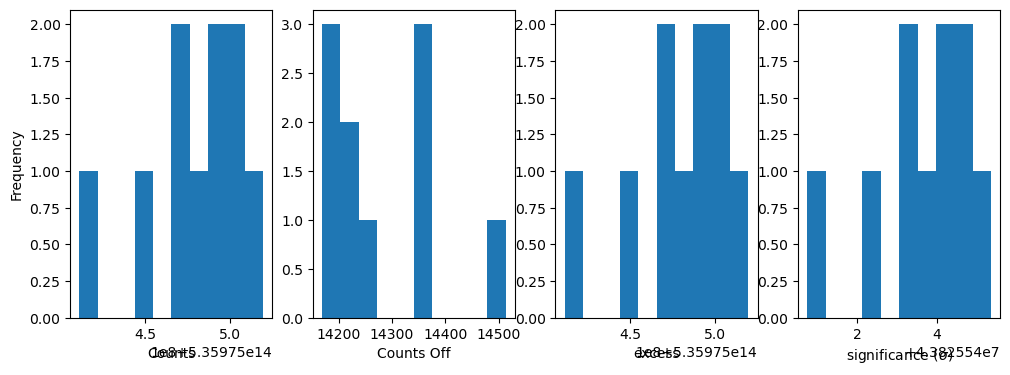

In [71]:
fix, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].hist(table["counts"])
axes[0].set_xlabel("Counts")
axes[0].set_ylabel("Frequency");

axes[1].hist(table["counts_off"])
axes[1].set_xlabel("Counts Off");

axes[2].hist(table["excess"])
axes[2].set_xlabel("excess");

axes[3].hist(table["sqrt_ts"])
axes[3].set_xlabel(r"significance ($\sigma$)");

path_counts = mkdir_base_child("analysis", "counts")

plt_savefig(path_counts, "counts")

<a id='step5.3'></a>
### Step 5.3: Computing the Sensitivity

  energy      e2dnde     excess background  criterion  
   TeV    erg / (cm2 s)                                
--------- ------------- ------- ---------- ------------
0.0310979   1.47996e-11 105.601        992 significance
0.0481186   9.20867e-12 92.7515        761 significance
0.0744552   3.53071e-12  74.987        492 significance
 0.115207   1.78864e-12 58.9927      299.8 significance
 0.178262   1.05413e-12  41.193      141.6 significance
  0.27583   7.19562e-13 31.1074         78 significance
      ...           ...     ...        ...          ...
  5.85755   5.61497e-13       5        0.2        gamma
  9.06355   8.19107e-13       5        0.2        gamma
  14.0243   1.12848e-12       5        0.2        gamma
  21.7001   1.89992e-12       5          0        gamma
  33.5772   3.42567e-12       5          0        gamma
  51.9549   4.78113e-12       5          0        gamma
  80.3913   4.67077e-12       5          0        gamma
Length = 19 rows


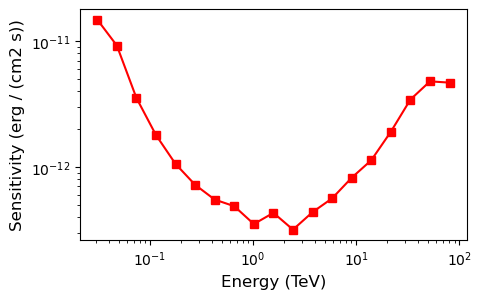

In [72]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, 
    n_sigma=3, 
    bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_onoff)
print(sensitivity_table)

# Plot the sensitivity curve
t = sensitivity_table

fix, axes = plt.subplots(figsize=(5, 3))

axes.plot(t["energy"], t["e2dnde"], "s-", color="red")
axes.loglog()

axes.set_xlabel(f"Energy ({t['energy'].unit})", size=12)
axes.set_ylabel(f"Sensitivity ({t['e2dnde'].unit})", size=12)

path_sens = mkdir_base_child("analysis", "sensitivity")

plt_savefig(path_sens, "sensitivity")

<a id='step5.4'></a>
### Step 5.4:  Computing the Flux Points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [73]:
#Compute flux points
datasets.models = [skymodel]

#fit_joint = Fit()
#result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = skymodel.copy()

energy_edges = MapAxis.from_energy_bounds("0.1 TeV", "30 TeV", nbin=12).edges

fpe = FluxPointsEstimator(energy_edges=energy_edges, source="model_simu", selection_optional="all")
flux_points = fpe.run(datasets=datasets)

print(flux_points.to_table(sed_type="dnde", formatted=True))

/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/

E VariableMetricBuilder Initial matrix not pos.def.


/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/datasets/core.py:224: RuntimeWarning: overflow encountered in double_scalars
  stat_sum += dataset.stat_sum()
/home/gamma/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/

e_ref  e_min  ...   norm_scan                     stat_scan                  
 TeV    TeV   ...                                                            
------ ------ ... -------------- --------------------------------------------
 0.115  0.093 ... 0.200 .. 5.000 1893626768712359.000 .. 1893626768712199.000
 0.178  0.143 ... 0.200 .. 5.000 2243622024743291.500 .. 2243622024743121.000
 0.276  0.222 ... 0.200 .. 5.000 2482081889893981.500 .. 2482081889893811.500
 0.531  0.343 ... 0.200 .. 5.000 4204459372409545.500 .. 4204459372409300.000
 1.022  0.821 ... 0.200 .. 5.000 1740049552707273.000 .. 1740049552707188.000
 1.581  1.271 ... 0.200 .. 5.000 1233955653246921.500 .. 1233955653246866.500
 2.447  1.967 ... 0.200 .. 5.000 1025529887574741.000 .. 1025529887574701.250
 3.786  3.043 ... 0.200 .. 5.000   703583119475795.375 .. 703583119475770.375
 5.858  4.709 ... 0.200 .. 5.000   511260707782611.375 .. 511260707782595.000
 9.064  7.286 ... 0.200 .. 5.000   350468968202789.500 .. 350468

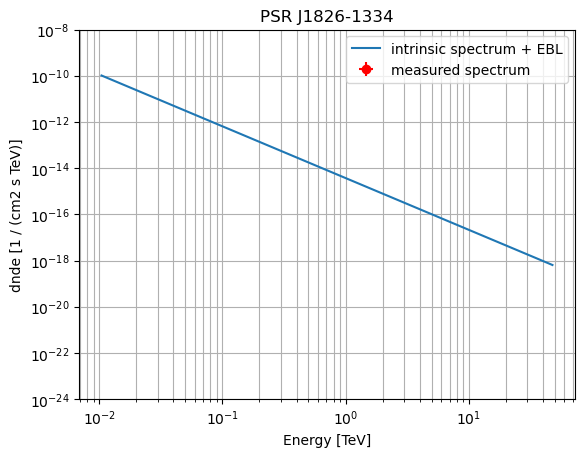

In [75]:
e_ref = []
e_min = []
e_max = []
dnde = []
dnde_err = []
subtract_emin = []
subtract_emax = []

for j in range(len(flux_points["energy_max"].value)):
    if flux_points["dnde"].data[j] > 0:
        e_ref.append(flux_points["energy_ref"].value[j])
        e_min.append(flux_points["energy_min"].value[j])
        e_max.append(flux_points["energy_max"].value[j])
        dnde.append(flux_points["dnde"].data[j][0])
        dnde_err.append(flux_points["dnde_err"].data[j][0])

flux_TEV = np.hstack((dnde))#*1e+06
flux_err_TEV = np.hstack((dnde_err))#*1e+06  
energy = np.hstack((e_ref))

#print(len(energy), len(flux_TEV))
#print(energy)
#print(np.asarray(flux_TEV))
#print(np.hstack((e_ref))-np.hstack((e_min)), np.hstack((e_max))-np.hstack((e_ref)))

energy_bounds = [0.01, 50] * u.TeV
plt.figure()
absspecmodel.plot(
    energy_bounds, 
    label='intrinsic spectrum + EBL'
)

xerr = [np.hstack((e_ref))-np.hstack((e_min)), np.hstack((e_max))-np.hstack((e_ref))]
plt.errorbar(
    e_ref, 
    flux_TEV, 
    color='red', 
    marker='o', 
    xerr = xerr, 
    yerr = flux_err_TEV, 
    linestyle='', 
    label='measured spectrum')
plt.grid(which="both")
plt.ylim(1e-24, 1e-8)
plt.legend(loc="best")
plt.title(src_name)

path_flux = mkdir_base_child("analysis", "flux_points")

plt_savefig(path_flux, "flux_points")

# plt.savefig('./spectrum_src_M87.png', bbox_inches='tight')

# plt.savefig('./M87_gammapy_flux_point.png', bbox_inches='tight')
# plt.savefig('./M87_gammapy_flux_point.pdf', bbox_inches='tight')

plt.show()


___

🔝 [Back to Top](#intro)<br>